## Imports

In [40]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold


%matplotlib inline

## Exploratory data analysis

In [13]:
df = pd.read_csv('bank-full.csv', sep=';')
print(df.shape)
df.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [14]:
df.drop(columns=['default', 'loan'], inplace=True)
df.isna().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [15]:
numerical_features = df.dtypes[df.dtypes != np.object_].index.values
categorical_features = df.dtypes[df.dtypes == np.object_].index.values

df[numerical_features].corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


In [16]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})

target = df.pop('y')

X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

categorical_features = np.delete(categorical_features, np.argmax(categorical_features == 'y'))

Split the data

In [17]:
df_train_dict = X_train[categorical_features].to_dict(orient='records')
df_val_dict = X_val[categorical_features].to_dict(orient='records')
df_test_dict = X_test[categorical_features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train_cat = dv.fit_transform(df_train_dict)
X_val_cat = dv.transform(df_val_dict)
X_test_cat = dv.transform(df_test_dict)

X_train_full = np.hstack([X_train[numerical_features].values, X_train_cat])
X_val_full = np.hstack([X_val[numerical_features].values, X_val_cat])
X_test_full = np.hstack([X_test[numerical_features].values, X_test_cat])

ROC-AUC of each feature

In [23]:
for i, feat in enumerate(list(numerical_features) + dv.feature_names_):
    score = roc_auc_score(y_train, X_train_full[:, i])
    print(f'ROC_AUC of {feat} = {round(max(score, 1 - score), 3)}')

ROC_AUC of age = 0.512
ROC_AUC of balance = 0.589
ROC_AUC of day = 0.526
ROC_AUC of duration = 0.815
ROC_AUC of campaign = 0.571
ROC_AUC of pdays = 0.59
ROC_AUC of previous = 0.599
ROC_AUC of contact=cellular = 0.595
ROC_AUC of contact=telephone = 0.507
ROC_AUC of contact=unknown = 0.602
ROC_AUC of education=primary = 0.522
ROC_AUC of education=secondary = 0.527
ROC_AUC of education=tertiary = 0.545
ROC_AUC of education=unknown = 0.505
ROC_AUC of housing=no = 0.605
ROC_AUC of housing=yes = 0.605
ROC_AUC of job=admin. = 0.501
ROC_AUC of job=blue-collar = 0.544
ROC_AUC of job=entrepreneur = 0.504
ROC_AUC of job=housemaid = 0.503
ROC_AUC of job=management = 0.521
ROC_AUC of job=retired = 0.526
ROC_AUC of job=self-employed = 0.501
ROC_AUC of job=services = 0.512
ROC_AUC of job=student = 0.518
ROC_AUC of job=technician = 0.511
ROC_AUC of job=unemployed = 0.506
ROC_AUC of job=unknown = 0.5
ROC_AUC of marital=divorced = 0.501
ROC_AUC of marital=married = 0.544
ROC_AUC of marital=single = 0.54

Train model

In [27]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train_full, y_train)

LogisticRegression(max_iter=1000, random_state=1, solver='liblinear')

Get validation score

In [33]:
y_pred_proba = model.predict_proba(X_val_full)[:, 1]
val_rocauc = roc_auc_score(y_val, y_pred_proba)
print(f'Validation ROC-AUC: {val_rocauc:.3f}')

Validation ROC-AUC: 0.900


Calculate PR, RC, F1

/home/eduard/mambaforge/envs/mix/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


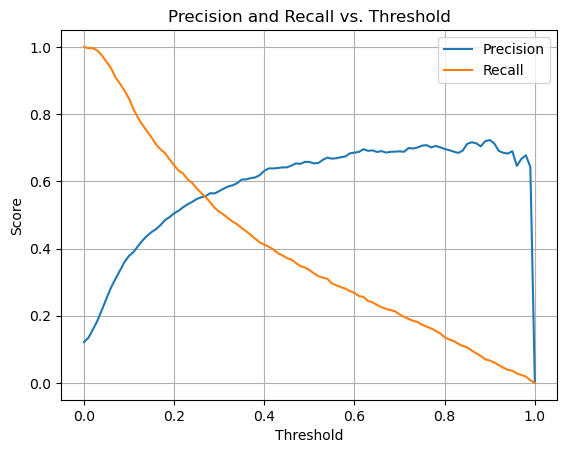

Precision and Recall intersect at threshold: 0.27


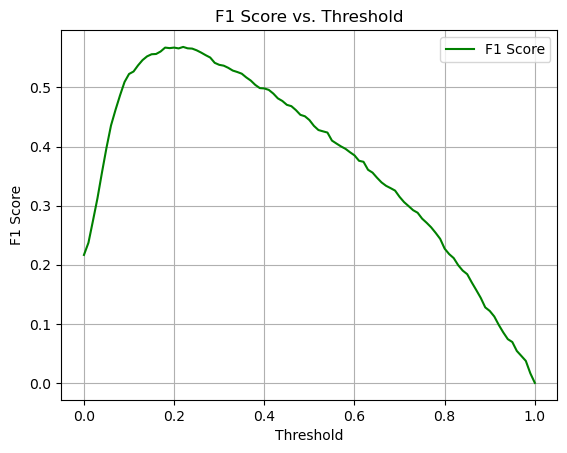

Maximum F1 score is at threshold: 0.22


In [39]:
thresholds = np.arange(0.0, 1.01, 0.01)

precision_list = []
recall_list = []
f1_list = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    precision_list.append(precision)
    recall_list.append(recall)
    
    f1 = f1_score(y_val, y_pred)
    f1_list.append(f1)

plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

for i in range(len(thresholds)):
    if np.isclose(precision_list[i], recall_list[i], atol=0.01):
        print(f'Precision and Recall intersect at threshold: {thresholds[i]}')
        break

plt.plot(thresholds, f1_list, label="F1 Score", color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.legend()
plt.show()

best_threshold = thresholds[np.argmax(f1_list)]
print(f'Maximum F1 score is at threshold: {best_threshold}')

5-Fold CV

In [41]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []

# Iterate over different folds
for train_index, val_index in kf.split(X_train_full):
    X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
    y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_proba)
    auc_scores.append(auc)

# Calculate mean and standard deviation of AUC scores
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f'Mean AUC: {mean_auc:.3f}')
print(f'Standard Deviation of AUC: {std_auc:.3f}')

Mean AUC: 0.908
Standard Deviation of AUC: 0.005


C tuning in 5-Fold CV

In [44]:
for C in [0.000001, 0.001, 1]:
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    auc_scores = []

    # Iterate over different folds
    for train_index, val_index in kf.split(X_train_full):
        X_train_fold, X_val_fold = X_train_full[train_index], X_train_full[val_index]
        y_train_fold, y_val_fold = y_train.values[train_index], y_train.values[val_index]

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)

        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # Calculate mean and standard deviation of AUC scores
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)

    print(f'C = {C}, Mean AUC: {mean_auc:.3f}')
    print(f'C = {C}, Standard Deviation of AUC: {std_auc:.3f}')

C = 1e-06, Mean AUC: 0.698
C = 1e-06, Standard Deviation of AUC: 0.005
C = 0.001, Mean AUC: 0.853
C = 0.001, Standard Deviation of AUC: 0.006
C = 1, Mean AUC: 0.908
C = 1, Standard Deviation of AUC: 0.005
